In [1]:
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from configobj import ConfigObj

# Custom modules from the project
from graphnet import EncodeProcessDecode
from Dataset import EfficientDataset

from scipy.interpolate import interpn

In [2]:
# Check if CUDA is available and set the device
gpu = 1
cuda_available = torch.cuda.is_available()
device = torch.device(f"cuda:{gpu}" if cuda_available else "cpu")

print(f"CUDA available: {cuda_available}")
print(f"Using device: {device}")

CUDA available: True
Using device: cuda:1


In [3]:
# Load the datacubes from the original C Porta code output
datadir = '../data_porta'
grid_file = '../en024048_hion/grid_bifrost.npz'
# Define the path to your best saved model
checkpoint_path = 'checkpoints/multistep_300/2025.08.01-08:06:50_best.pth' # Make sure this path is correct
# checkpoint_path = 'checkpoints/cos_annealing_300/2025.07.31-09:06:14_best.pth' # Make sure this path is correct

nx = ny = 504
nz = 476 - 52 + 1  # 425
new_nz = 64
batch_size = 64

# Use memory-mapped arrays to handle large files efficiently
pops_orig = np.memmap(f'{datadir}/AR_385_CaII_5L_pops.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 6))
b_xyz_orig = np.memmap(f'{datadir}/AR_385_B.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 3))
temp_orig = np.memmap(f'{datadir}/AR_385_temp.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 1))
vel_orig = np.memmap(f'{datadir}/AR_385_veloc.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 3))
n_e_orig = np.memmap(f'{datadir}/AR_385_ne.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 1))
n_h_orig = np.memmap(f'{datadir}/AR_385_nh.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 1))
n_p_orig = np.memmap(f'{datadir}/AR_385_np.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 1))

In [4]:
# Interpolate the data to the model's expected input dimensions (new_nz, 504, 504)
z, y, x = (np.arange(d) for d in (nz, ny, nx))
new_z, new_y, new_x = (np.linspace(0, d-1, new_d) for d, new_d in zip((nz, ny, nx), (new_nz, ny, nx)))
new_zv, new_yv, new_xv = np.meshgrid(new_z, new_y, new_x, indexing='ij', sparse=True)
new_points = (new_zv, new_yv, new_xv)

print(f"Interpolating data to the new grid ({new_nz}, {ny}, {nx})...")
pops = interpn((z, y, x), pops_orig, new_points)
temp = interpn((z, y, x), temp_orig, new_points)
b_xyz = interpn((z, y, x), b_xyz_orig, new_points)
vel = interpn((z, y, x), vel_orig, new_points)
n_e = interpn((z, y, x), n_e_orig, new_points)
n_h = interpn((z, y, x), n_h_orig, new_points)
n_p = interpn((z, y, x), n_p_orig, new_points)
print("Interpolation complete.")

Interpolating data to the new grid (64, 504, 504)...
Interpolation complete.


In [5]:
pops_orig.shape

(425, 504, 504, 6)

In [6]:
pops.shape

(64, 504, 504, 6)

In [7]:
# Normalize features and targets as done during training
features_list = [(vel - vel.mean())/vel.std(),
                 np.sign((b_xyz-b_xyz.mean())/b_xyz.std())*abs((b_xyz-b_xyz.mean())/b_xyz.std())**(1/4), 
                 np.log10(temp/temp.mean()),
                 np.log10(1/(n_h/n_h.mean()))/10, np.log10(1/(n_e/n_e.mean()))/10, np.log10(1/(n_p/n_p.mean()))/10]
targets_list = [np.log10(1/(pops/pops.sum(axis=-1, keepdims=True)))**(1/4)]

# features_list = [(vel - vel.mean())/vel.std(),
#                  (b_xyz-b_xyz.mean())/b_xyz.std(), 
#                  np.log10(temp),
#                  np.log10(n_h),
#                  np.log10(n_e),
#                  np.log10(n_p)]
# targets_list = [pops/pops.sum(axis=-1, keepdims=True)]

features_labels = ['vx', 'vy', 'vz', 'bx', 'by', 'bz', 'temp', 'nh', 'ne', 'np']

# Create the test dataset and loader
datast_test = EfficientDataset(
    features_list,
    targets_list,
    pos_file=grid_file,
    radius_neighbors=1.77,
    split='test'  # Ensure we are using the test set
)

loader_test = DataLoader(datast_test, batch_size=batch_size, shuffle=False) # No need to shuffle for inference

Test dataset created. Total samples: 25201
Features shape: (16257024, 10), Targets shape: (16257024, 6)


In [8]:
# count the number of nans:
print(np.isnan(datast_test.features).sum(axis=0)/datast_test.features.shape[0])
print(np.isnan(datast_test.targets).sum(axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0]


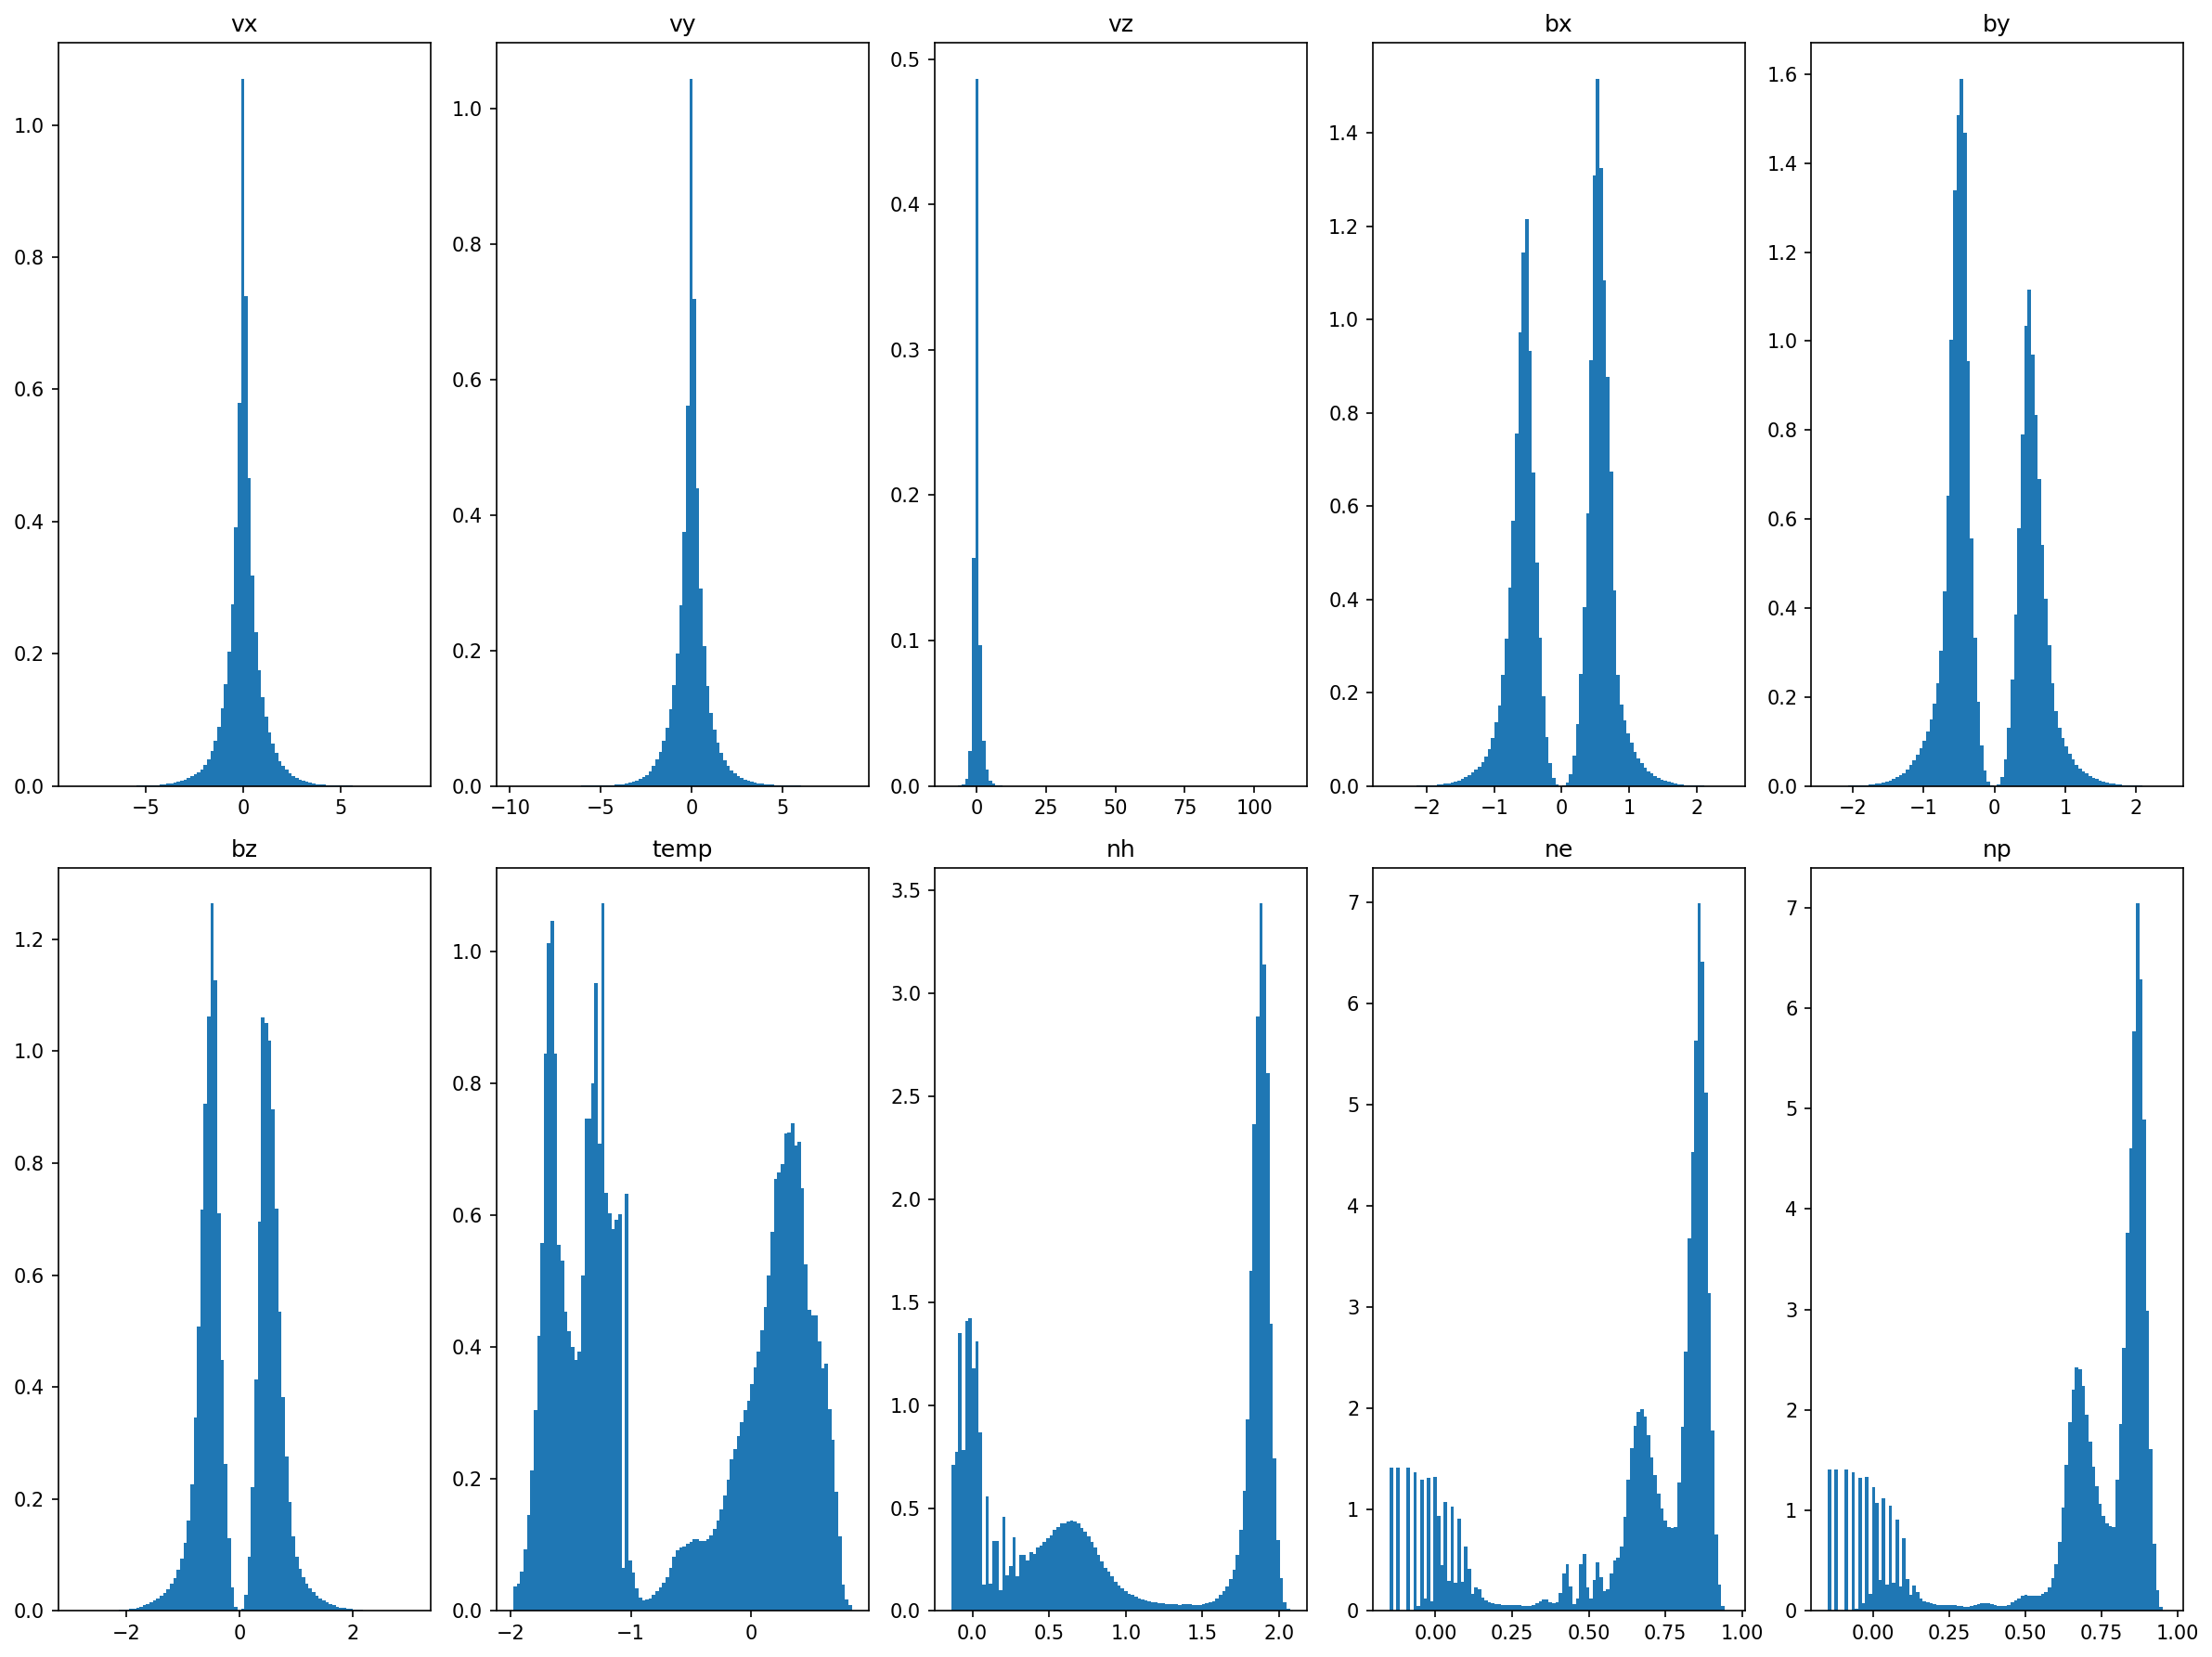

In [9]:
plt.figure(0,(16,12), 150)

for i in range(datast_test.features.shape[1]):
    plt.subplot(2,5,i+1)
    plt.title(features_labels[i])
    plt.hist(datast_test.features[:,i],100, density=True)
plt.tight_layout()
plt.show()

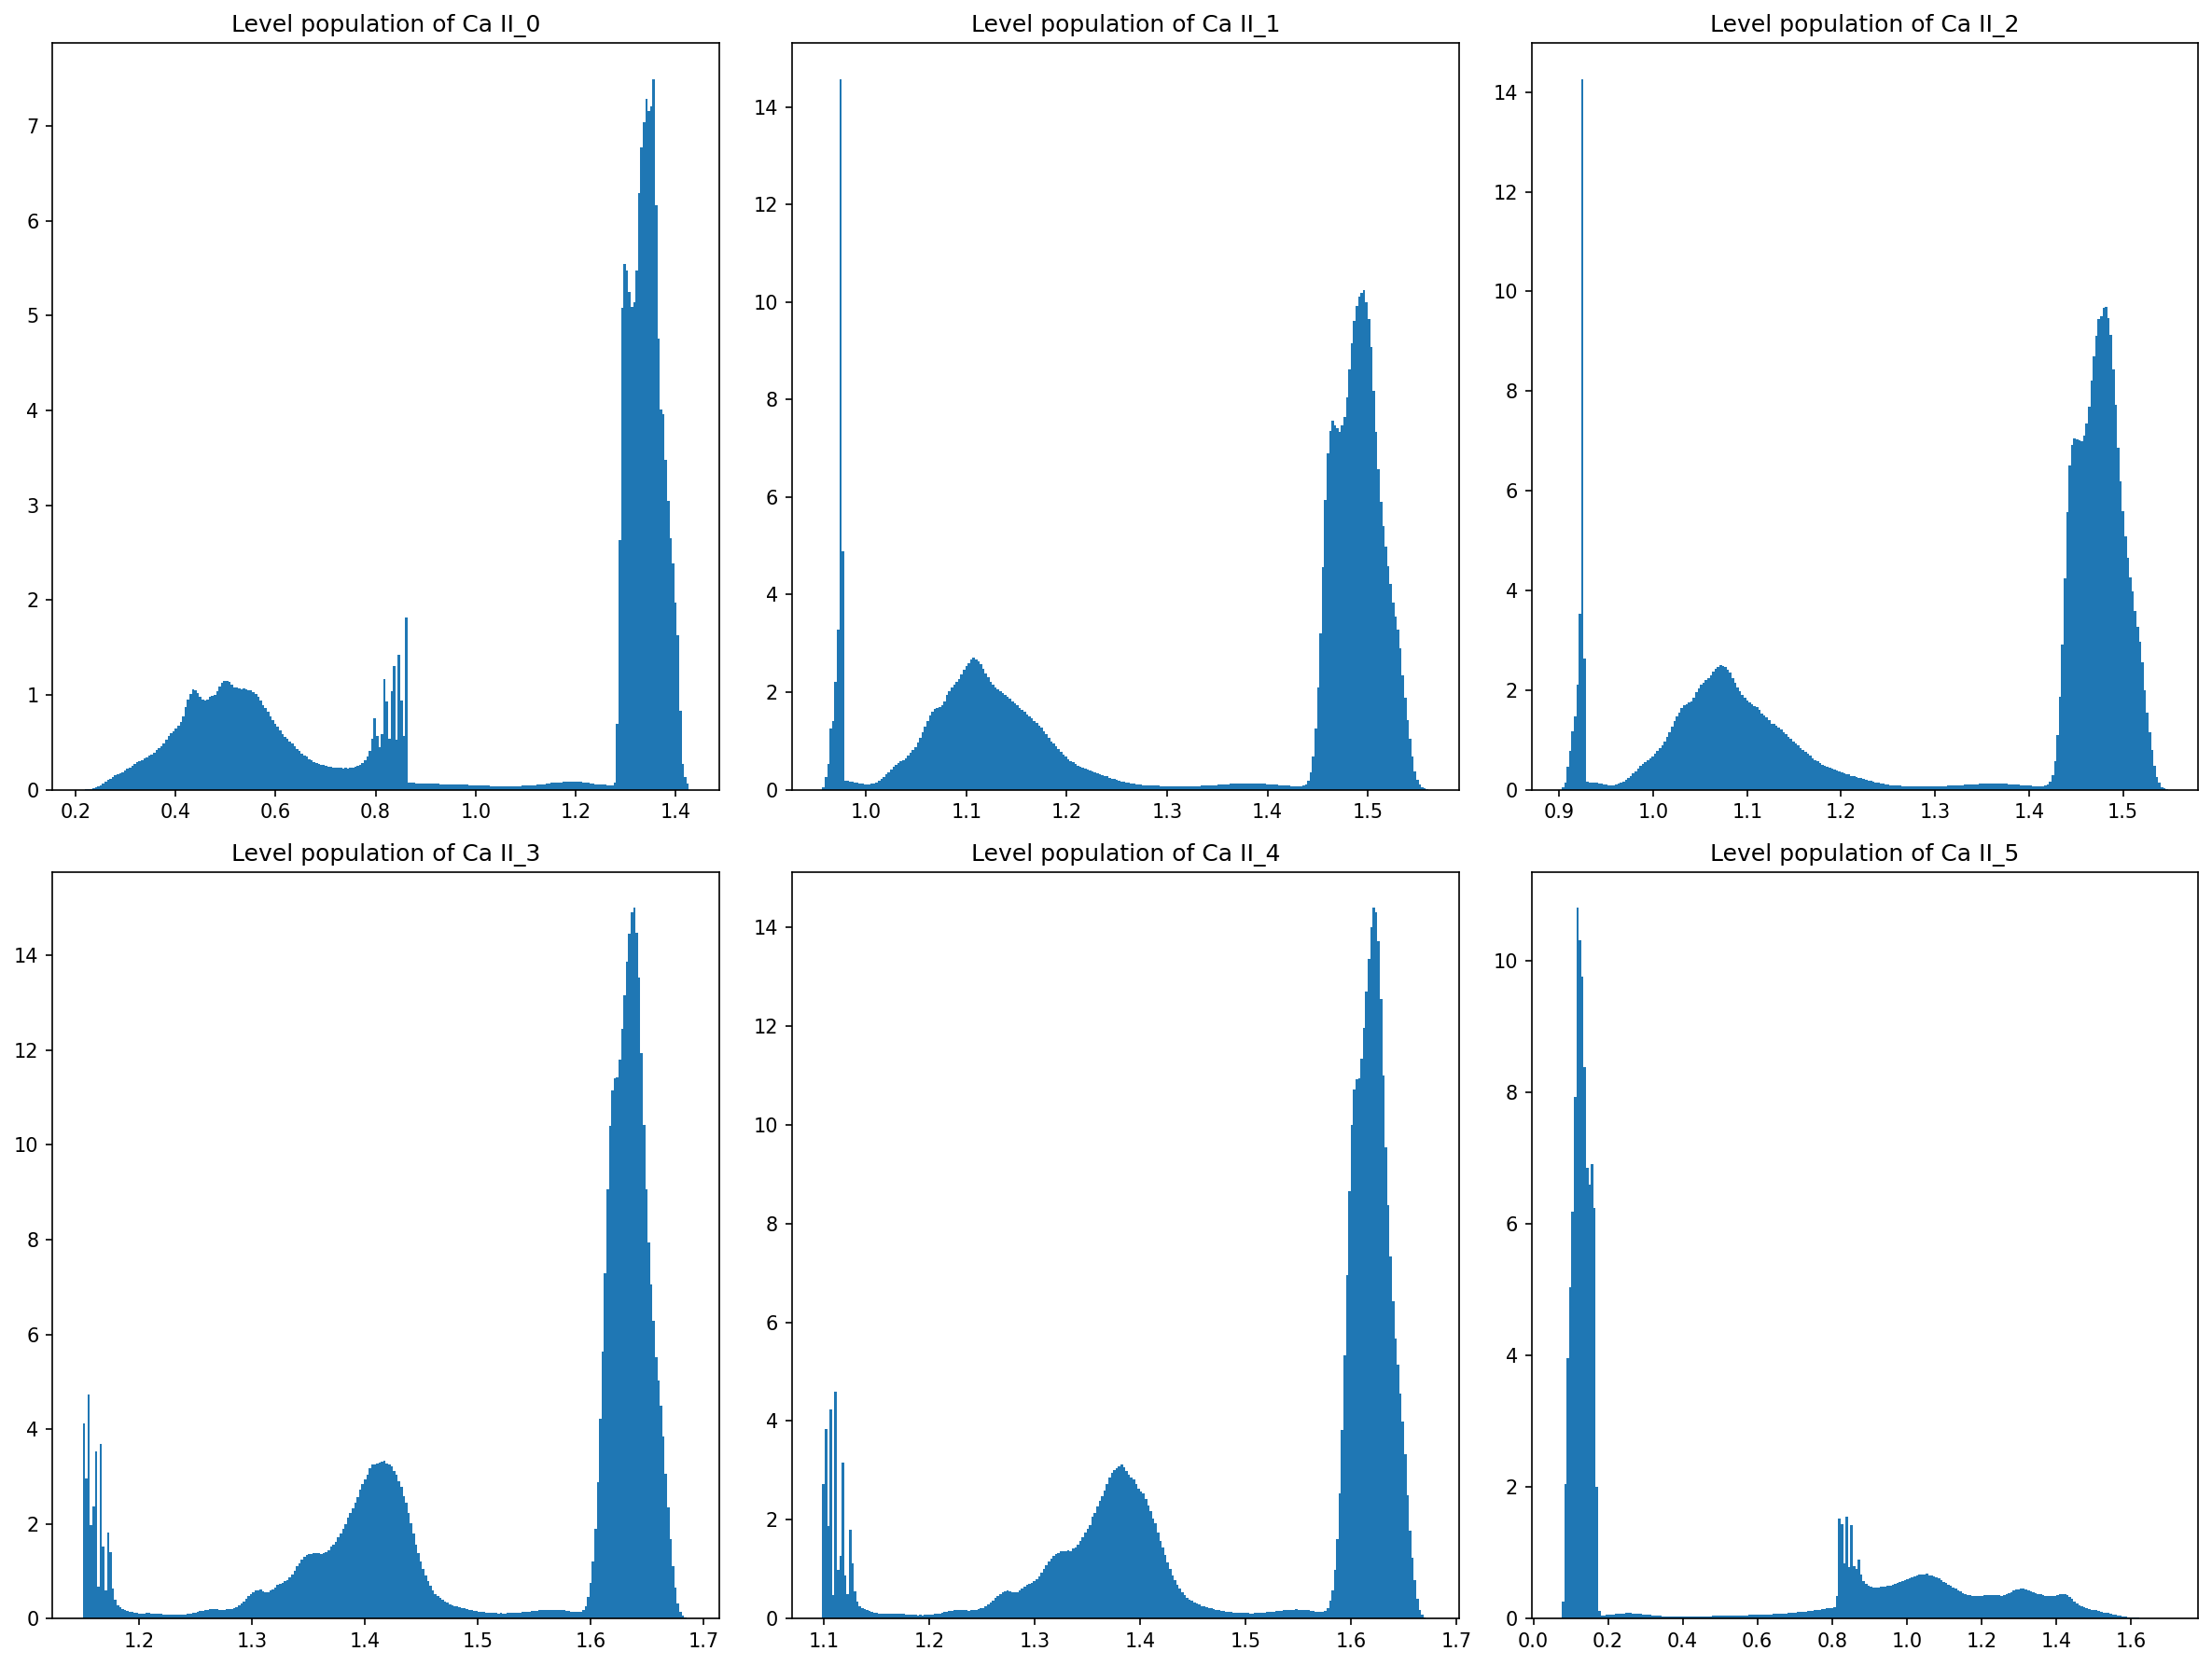

In [10]:
plt.figure(0,(16,12), 150)
for i in range(datast_test.targets.shape[1]):
    plt.subplot(2,3,i+1)
    plt.title(f'Level population of Ca II_{i}')
    plt.hist(datast_test.targets[:,i],250, density=True)
plt.tight_layout()
plt.show()

In [12]:
# Load the checkpoint dictionary
# Use map_location to ensure the model loads correctly on CPU if it was trained on GPU
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Extract hyperparameters and instantiate the model
hyperparameters = checkpoint['hyperparameters']
for k, v in hyperparameters.items(): # Ensure hyperparameters are integers
    hyperparameters[k] = int(v)

model = EncodeProcessDecode(**hyperparameters).to(device)

# Load the trained weights into the model
model.load_state_dict(checkpoint['state_dict'])

print("Model loaded successfully from checkpoint.")
print(f"Loaded model from epoch {checkpoint['epoch']} with best validation loss: {checkpoint['best_loss']:.6f}")

Model loaded successfully from checkpoint.
Loaded model from epoch 299 with best validation loss: 0.000931


In [13]:
all_predictions = []
all_targets = []

model.eval() # Set the model to evaluation mode

print("Running inference on the test set...")
with torch.no_grad(): # Disable gradient calculations for inference
    for data in tqdm(loader_test):
        # Move data to the selected device
        node, edge_attr, edge_index = data.x.to(device), data.edge_attr.to(device), data.edge_index.to(device)
        u, batch, target = data.u.to(device), data.batch.to(device), data.y.to(device)

        # Get model prediction
        out = model(node, edge_attr, edge_index, u, batch)

        # Store predictions and targets
        # Move them to CPU and convert to NumPy arrays for analysis
        all_predictions.append(out.cpu().numpy())
        all_targets.append(target.cpu().numpy())

# Concatenate all batch results into single NumPy arrays
predictions = np.concatenate(all_predictions, axis=0)
targets = np.concatenate(all_targets, axis=0)

print("Inference complete.")
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

Running inference on the test set...


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

Inference complete.
Predictions shape: (1451520, 6)
Targets shape: (1451520, 6)


In [14]:
# Calculate residuals and Mean Absolute Error (MAE)
residuals = (predictions - targets)/targets
mae = np.mean(np.abs(residuals), axis=0)

print(f"Mean Absolute Error for each of the 6 target features: {mae}")

Mean Absolute Error for each of the 6 target features: [0.03705408 0.01161718 0.01291519 0.00684688 0.0074712  0.07458729]


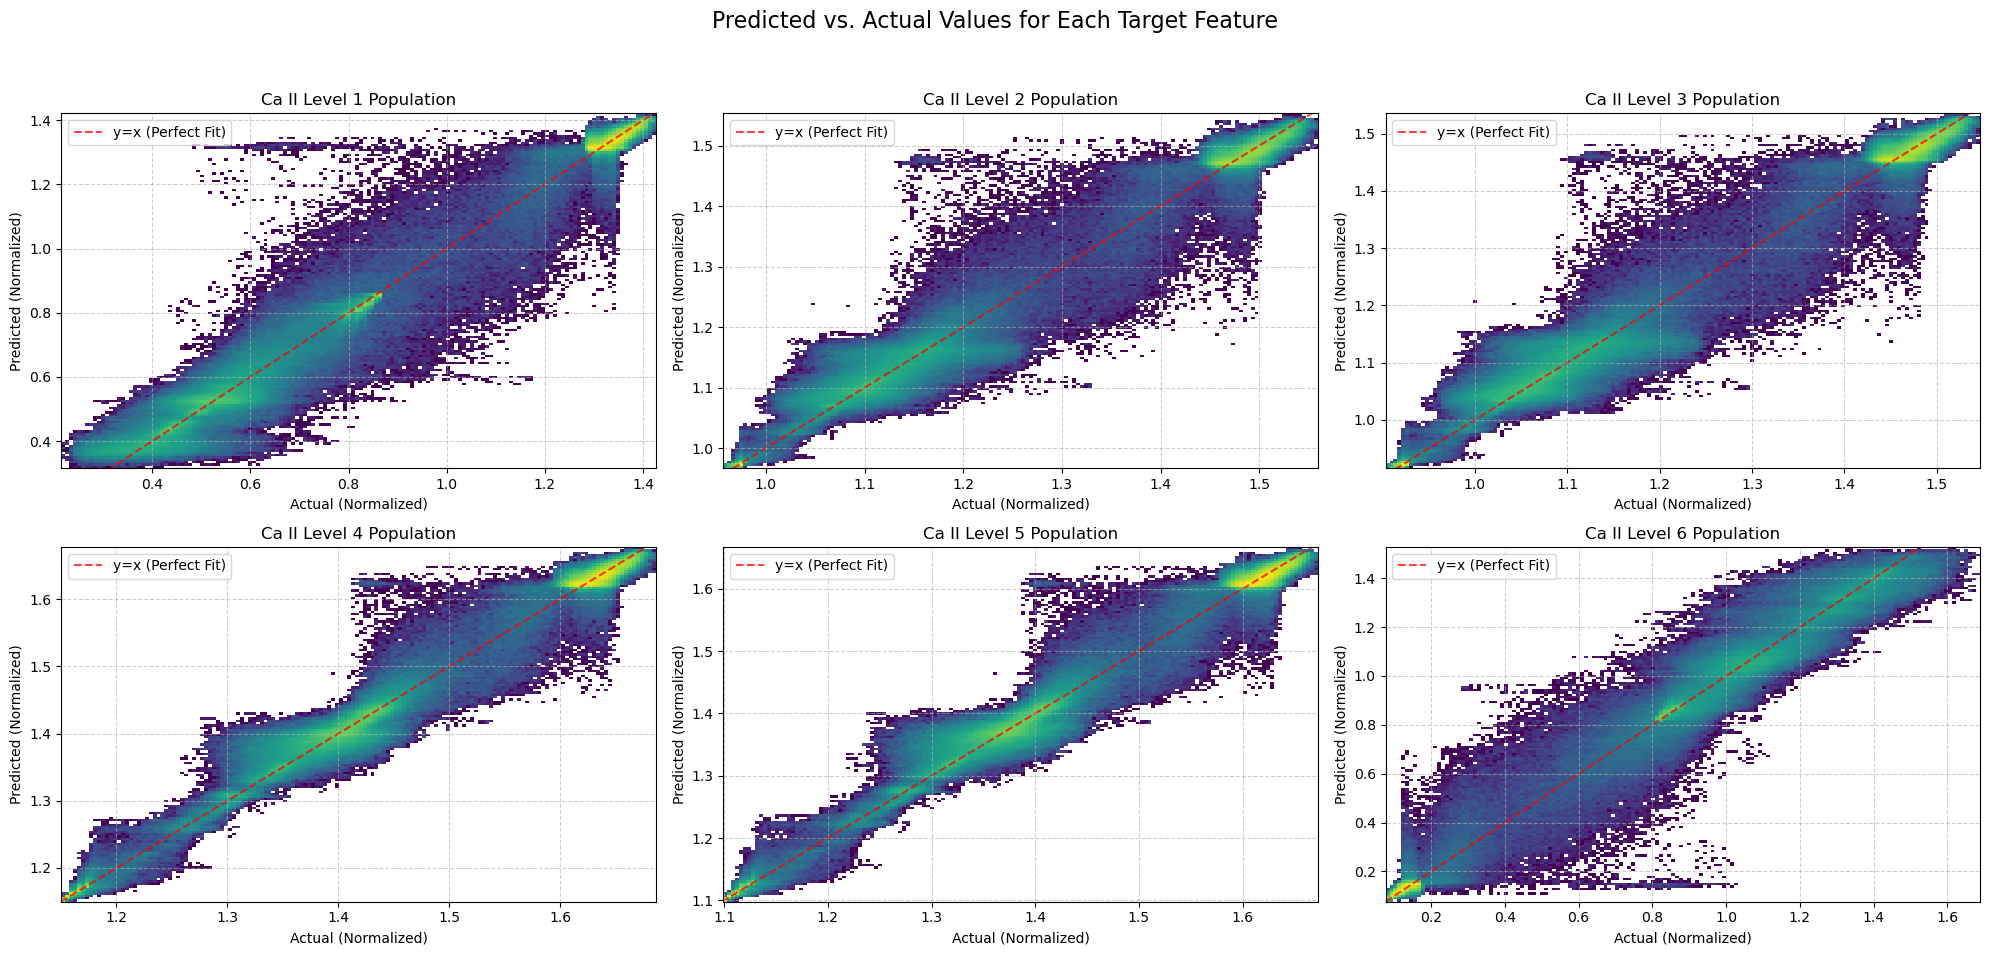

In [15]:
# The target variable (level populations) has 6 dimensions. We'll create a plot for each.
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.flatten()
import matplotlib.colors as colors

for i in range(predictions.shape[1]):
    ax = axes[i]

    # To avoid plotting millions of points, we take a random sample
    # sample_indices = np.random.choice(len(predictions), size=int(1e5), replace=False)
    # ax.scatter(targets[sample_indices, i], predictions[sample_indices, i], alpha=0.1, s=1)
    # ax.scatter(targets[:, i], predictions[:, i], alpha=0.05, s=0.5)
    ax.hist2d(targets[:, i], predictions[:, i], 150, norm=colors.LogNorm())
    
    # Add the y=x line for reference
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=1, label='y=x (Perfect Fit)')
    
    ax.set_title(f'Ca II Level {i+1} Population')
    ax.set_xlabel('Actual (Normalized)')
    ax.set_ylabel('Predicted (Normalized)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left')

fig.suptitle('Predicted vs. Actual Values for Each Target Feature', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

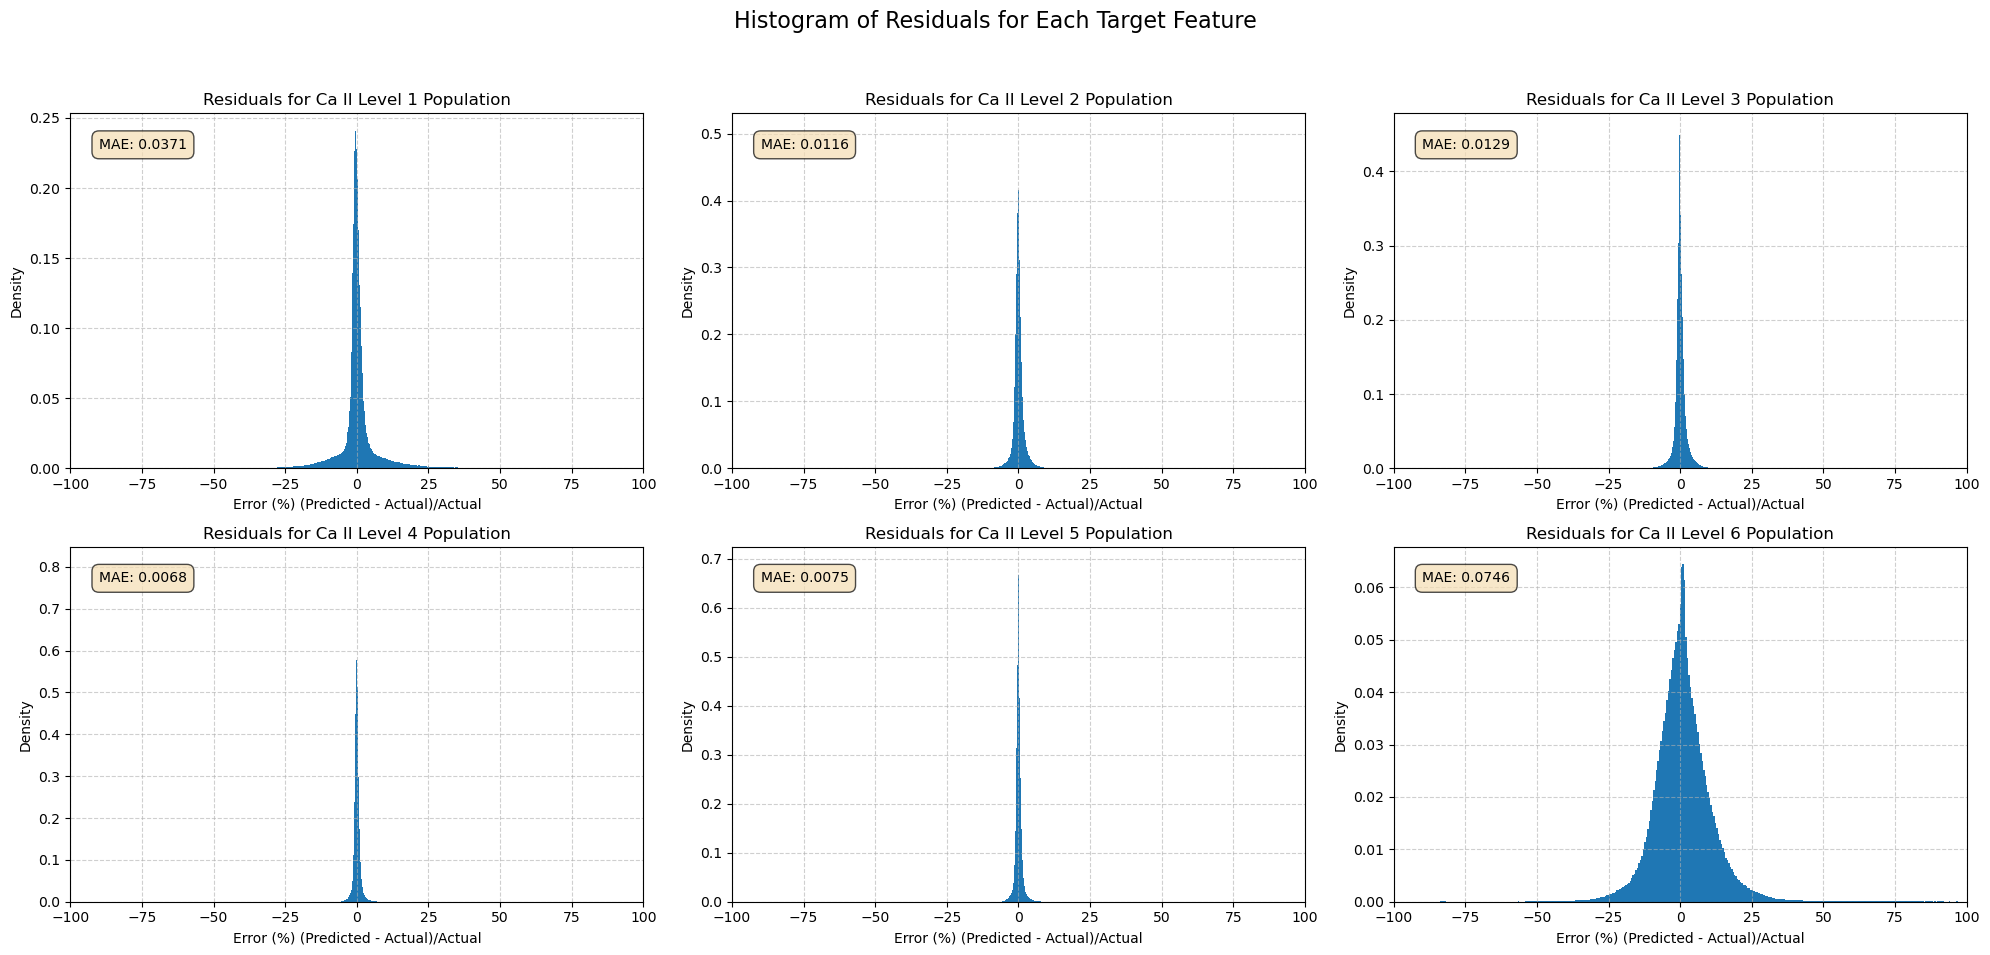

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.flatten()

for i in range(residuals.shape[1]):
    ax = axes[i]
    ax.hist(residuals[:, i]*100, bins=1000, density=True)
    ax.set_title(f'Residuals for Ca II Level {i+1} Population')
    ax.set_xlabel('Error (%) (Predicted - Actual)/Actual')
    ax.set_ylabel('Density')
    # ax.set_yscale('log')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add text for Mean Absolute Error
    ax.text(0.05, 0.9, f'MAE: {mae[i]:.4f}', transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
    
    ax.set_xlim(-100,100)

fig.suptitle('Histogram of Residuals for Each Target Feature', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [17]:
# Step 1: Calculate the sum of populations for each node before flattening
# This is needed to revert from fractional to absolute populations.
pops_sum = pops.sum(axis=-1, keepdims=True)

# Step 2: Reshape the sums to match the flattened structure of the predictions array
pops_sum_flat = pops_sum.reshape(-1, 1)

# Step 3: The test data is a slice of the full dataset.
# We need to get the corresponding sum values for the test samples.
# Since shuffle=False in the test loader, we can take the last N samples.
pops_sum_test = pops_sum_flat[-len(predictions):]

# Step 4: Define the denormalization function
def denormalize_pops(normalized_data, sums):
    """Reverts the normalization process for population data."""
    fractional_pops = 1 / (10**(normalized_data**4))
    return fractional_pops * sums

# Step 5: Apply the denormalization to both predictions and ground truth targets
predictions_orig = denormalize_pops(predictions, pops_sum_test)
targets_orig = denormalize_pops(targets, pops_sum_test)

# Step 6: Calculate error metrics in the original physical space
residuals_orig = predictions_orig - targets_orig
mae_orig = np.mean(np.abs(residuals_orig), axis=0)
mape_orig = np.mean(np.abs(residuals_orig / targets_orig), axis=0) * 100

print("--- Error Metrics in Original Space ---")
print(f"Mean Absolute Error for each level: {mae_orig}")
print(f"Mean Absolute Percentage Error for each level (%): {mape_orig}")

--- Error Metrics in Original Space ---
Mean Absolute Error for each level: [6.49542292 0.8969372  1.38665295 0.02551949 0.05053498 5.36389656]
Mean Absolute Percentage Error for each level (%): [ 30.64890108  38.62110283  39.52983861  38.18036694  39.290408
 172.72228633]


In [23]:
# --- Verification Cell ---

# 1. Take a small, manageable slice of the original interpolated data
pops_sample = pops[:2, :2, :2, :]

# 2. Calculate the sum for this specific sample, as required by the functions
pops_sum_sample = pops_sample.sum(axis=-1, keepdims=True)

# 3. Define the normalization function exactly as used in preprocessing
def normalize_pops(data, sums):
    # Add a small epsilon to prevent division by zero or log(0) for populations that are zero
    epsilon = 1e-9
    fractional_pops = data / (sums + epsilon)
    # Clamp values to prevent log of values <= 0
    fractional_pops[fractional_pops <= 0] = epsilon
    return np.log10(1 / fractional_pops)**(1/4)

# 4. Normalize the sample
normalized_sample = normalize_pops(pops_sample, pops_sum_sample)

# 5. Denormalize the result using the function defined previously
denormalized_sample = denormalize_pops(normalized_sample, pops_sum_sample)

# 6. Check if the original and the round-tripped data are numerically close
are_they_close = np.allclose(pops_sample, denormalized_sample)

# 7. Print the results for inspection
print("--- Verification Results ---")
print(f"Original Data Sample Mean:\n{pops_sample.mean()}\n")
print(f"Normalized Sample Mean:\n{normalized_sample.mean()}\n")
print(f"Denormalized (Round-trip) Sample Mean:\n{denormalized_sample.mean()}\n")
print("-" * 20)
print(f"Verification Successful: {are_they_close}")

if not are_they_close:
    print("\nWarning: The denormalized data is NOT the same as the original.")
    print(f"Difference:\n{pops_sample - denormalized_sample}")

--- Verification Results ---
Original Data Sample Mean:
158025749053.29102

Normalized Sample Mean:
0.9724957604478529

Denormalized (Round-trip) Sample Mean:
158025749053.29102

--------------------
Verification Successful: True


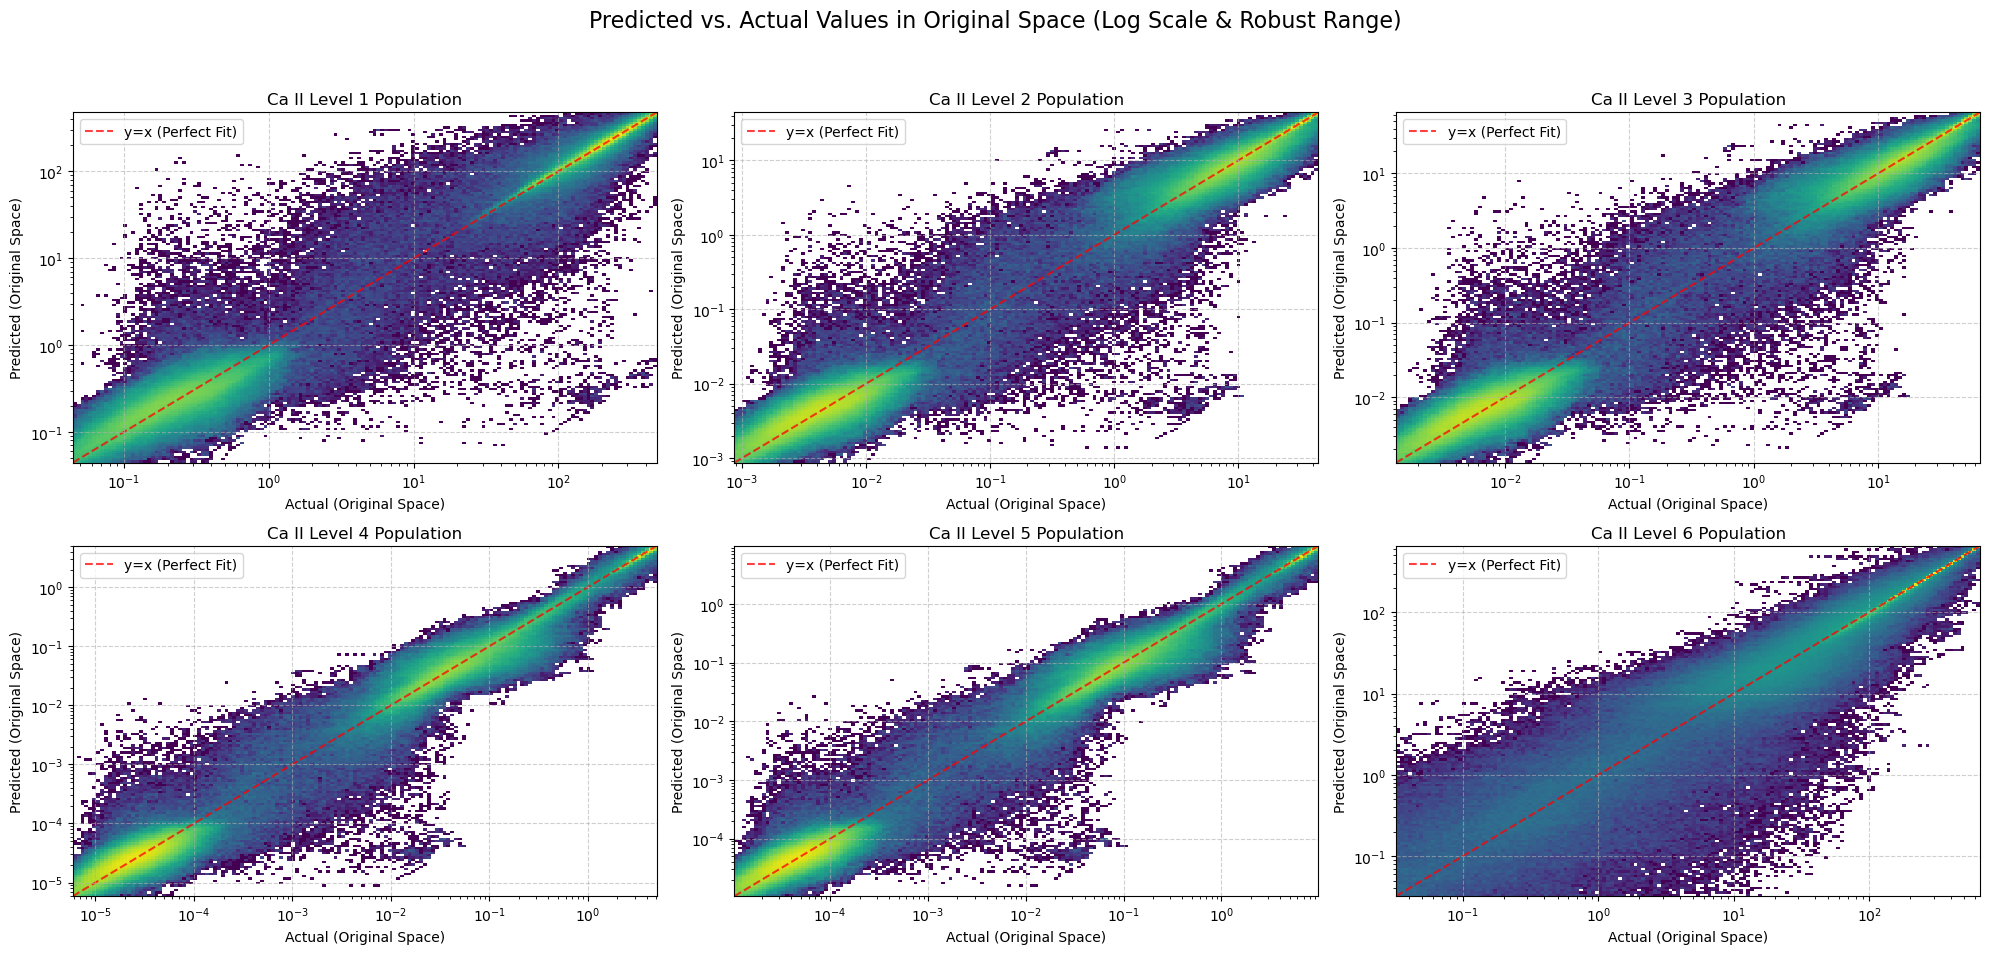

In [24]:
# Plot predicted vs. actual values with robust, log-spaced bins
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.flatten()
import matplotlib.colors as colors

for i in range(predictions_orig.shape[1]):
    ax = axes[i]
    
    # Isolate data for clarity
    x_data = targets_orig[:, i]
    y_data = predictions_orig[:, i]

    # --- New: Define a robust range using percentiles to exclude outliers ---
    x_min, x_max = np.percentile(x_data[x_data>0], [3, 97]) # Exclude zeros for log
    y_min, y_max = np.percentile(y_data[y_data>0], [3, 97])
    
    # Use the overall min/max of the percentile ranges for a square plot
    plot_min = min(x_min, y_min)
    plot_max = max(x_max, y_max)

    # --- New: Create logarithmically spaced bins ---
    # This is crucial for proper visualization on a log-scaled axis
    bins = np.logspace(np.log10(plot_min), np.log10(plot_max), 151)

    # Use a 2D histogram with log normalization for the color scale
    ax.hist2d(x_data, y_data, bins=[bins, bins], norm=colors.LogNorm())
    
    # Set both axes to a logarithmic scale
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Add the y=x line for reference, using the robust limits
    ax.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', alpha=0.75, zorder=1, label='y=x (Perfect Fit)')
    
    ax.set_title(f'Ca II Level {i+1} Population')
    ax.set_xlabel('Actual (Original Space)')
    ax.set_ylabel('Predicted (Original Space)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left')

fig.suptitle('Predicted vs. Actual Values in Original Space (Log Scale & Robust Range)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

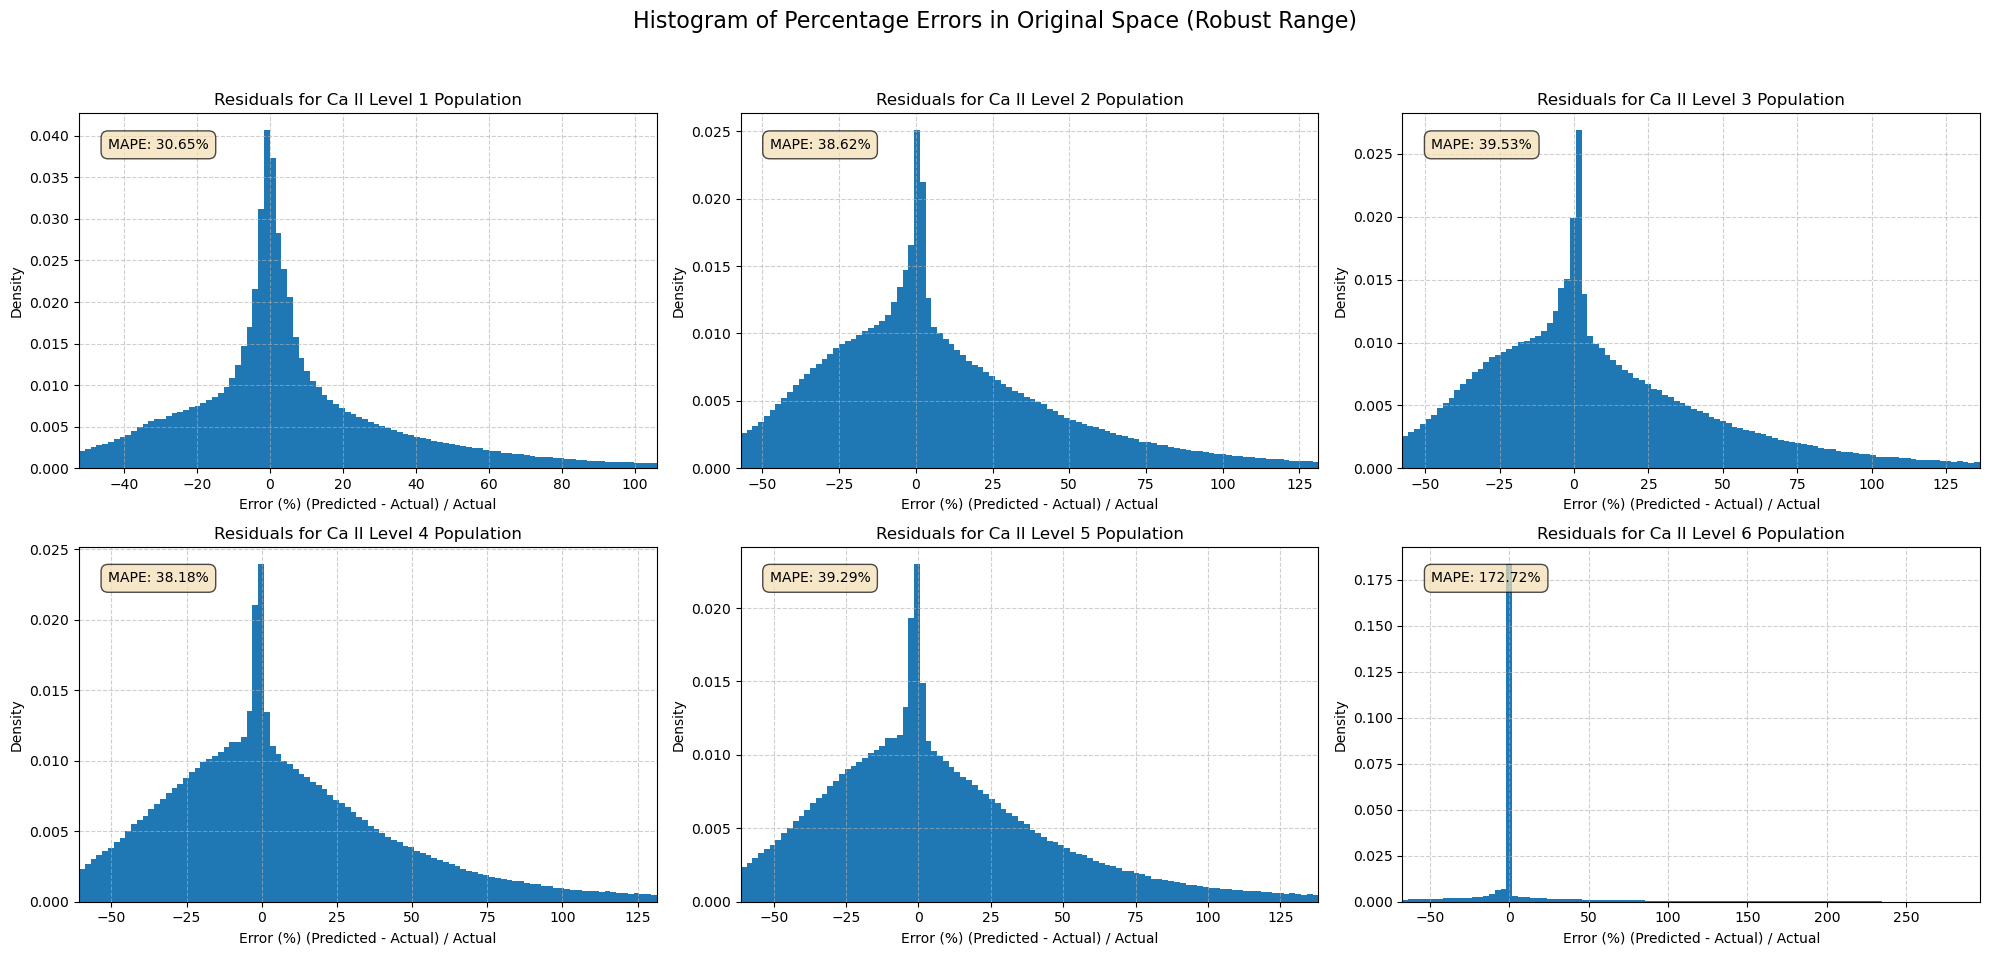

In [25]:
# Calculate the percentage error in the original space
residuals_percent = (residuals_orig / targets_orig) * 100

# Plot histograms of the percentage errors with a robust range
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.flatten()

for i in range(residuals_percent.shape[1]):
    ax = axes[i]
    
    # Isolate data for the current subplot
    data = residuals_percent[:, i]
    
    # --- New: Define a robust range using percentiles ---
    p3, p97 = np.percentile(data, [3, 97])
    
    # Use the 'range' argument to focus the histogram on the 3-97 percentile data
    ax.hist(data, bins=100, range=(p3, p97), density=True)
    
    ax.set_title(f'Residuals for Ca II Level {i+1} Population')
    ax.set_xlabel('Error (%) (Predicted - Actual) / Actual')
    ax.set_ylabel('Density')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add text for Mean Absolute Percentage Error
    ax.text(0.05, 0.9, f'MAPE: {mape_orig[i]:.2f}%', transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
    
    # Set x-limits to match the percentile range for a clean plot
    ax.set_xlim(p3, p97)

fig.suptitle('Histogram of Percentage Errors in Original Space (Robust Range)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()